## Init

In [1]:
!module load pytorch-gpu/py3/1.10.0
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-8d152578-fa66-7ede-a238-fabba5eaa6bb)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import modellib
import datalib
import training
import conf
from multiprocessing import Pool

%load_ext autoreload
%autoreload 2

/gpfslocalsup/pub/anaconda-py3/2021.05/envs/pytorch-gpu-1.11.0+py3.9.12/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


## Loading data 

In [3]:
dataset = datalib.SimulationBatch.load()

/gpfslocalsup/pub/anaconda-py3/2021.05/envs/pytorch-gpu-1.11.0+py3.9.12/lib/python3.9/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


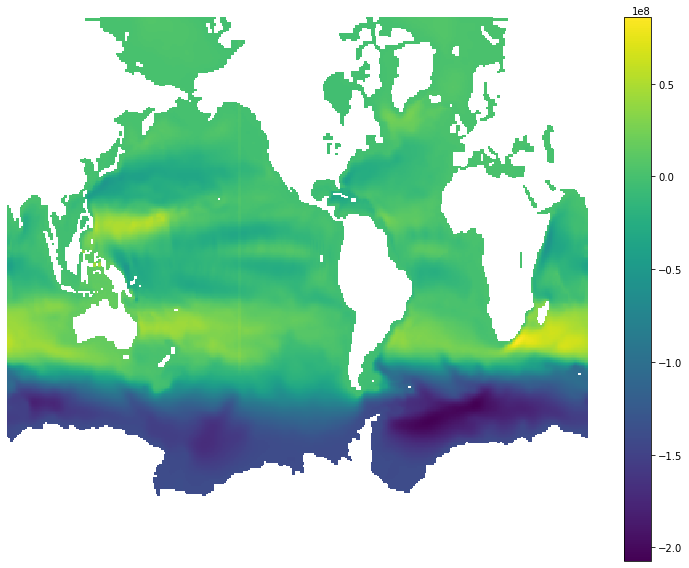

In [4]:
plt.figure(figsize=(13, 10)) ; plt.pcolor(dataset[0][450]) ; plt.colorbar() ; plt.axis('off') ; plt.show()

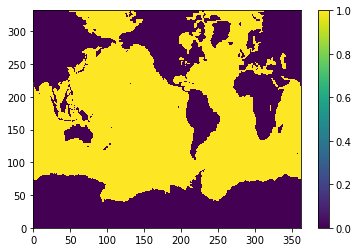

In [5]:
dataset.load_mask_bathy()
plt.pcolor(dataset.mask) ; plt.colorbar() ; plt.show()

## Data conversion

Remove annual cycles, average annually, infer mask, etc.

/gpfsdswork/projects/idris/sos/ssos025/pnria/hrmes/datalib.py:59: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /gpfs7kro/gpfslocalsup/src/pub/anaconda-py3/2021.05/pytorch-1.11.0+py3.9.12/pytorch-1.11.0/aten/src/ATen/native/TensorShape.cpp:2318.)
  dataset = torch.from_numpy(dataset).T


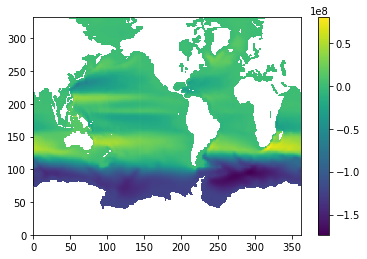

In [6]:
#dataset.convert2ssca()
dataset.convert2annual()
plt.pcolor(dataset[0][120]) ; plt.colorbar() ; plt.show()

In [7]:
dataset.infer_mask()

In [8]:
dataset.normalize(method="pointwise_stats")

In [9]:
dataset.apply_mask()

## PCA 

In [179]:
pca = dataset.compute_pca(1000, transform=False)

In [ ]:
plt.plot(range(1, 1001), 1 - np.cumsum(pca.explained_variance_ratio_), "b-")
plt.yscale("log")
plt.ylabel("Unexplained variance")
plt.xlabel("N_components")
plt.show()

In [10]:
dataset.compute_pca(1, transform=True)
dataset.to_torch()
[(sim.shape, sim.dtype) for sim in dataset]

[((240, 332, 362), dtype('float32')),
 ((600, 332, 362), dtype('float32')),
 ((240, 332, 362), dtype('float32'))]

In [13]:
for i in range(3):
    with open(f"simu{i+1}.npy", "rb") as file:
        print(np.load(file).shape)

(240, 1)
(600, 1)
(240, 1)


In [12]:
for i in range(len(dataset.masked_simulations)):
    with open(f"simu{i+1}.npy", "wb") as file:
        np.save(file, dataset.masked_simulations[i].cpu().detach().numpy())
    print(dataset.masked_simulations[i].cpu().detach().numpy().shape)

(240, 1)
(600, 1)
(240, 1)


In [ ]:
import random

plt.figure(figsize=(25,10))
for i in range(len(dataset.masked_simulations)):
    plt.subplot(1, len(dataset.masked_simulations), i+1)
    for j in range(5):
        plt.plot(dataset.masked_simulations[i][::5, j], label=f"component {j+1}")
    plt.legend()
plt.show()

In [13]:
from eofs.standard import Eof

eof = []
pc = []
for simulation in dataset:
    solver = Eof(simulation)
    eof.append(solver.eofsAsCovariance(neofs=3))
    pc.append(solver.pcs(npcs=3, pcscaling=1))

In [ ]:
plt.figure(figsize=(24, 30))
k = 0
for i in range(3):
    for j in range(3):
        k += 1
        plt.subplot(6, 3, k)
        plt.pcolor(eof[i][j])
        plt.colorbar()
        plt.title(f"Simulation {i + 1} | Component {j + 1}")
    for j in range(3):
        k += 1
        plt.subplot(6, 3, k)
        plt.plot(pc[i][:, j])
        plt.title(f"Simulation {i + 1} | Component {j + 1}")

plt.show()

## Training preparation

In [40]:
dataset.make_input_indices()

In [41]:
train_ds, test_ds = dataset.train_test_ds()
print(len(train_ds), len(test_ds))

834 210


In [42]:
train_ds[0][0].shape

torch.Size([12, 1])

In [43]:
train_dataloader, test_dataloader = dataset.make_dataloaders(train_ds, test_ds)

In [46]:
model, criterion, optimizer = modellib.define_model_optimizer_criterion(pca_model=True)

Model has 100353 parameters


## Training 

In [47]:
train_losses, test_losses = training.train(model, conf.epochs, train_dataloader, test_dataloader, optimizer, criterion, bool_mask=None)
plt.figure()
plt.plot(train_losses, "r-", label="Training loss")
if conf.epochs != 1:
    plt.plot(test_losses, "b-", label="Test loss")
plt.legend()
plt.show()
print(f"Final test loss: {test_losses[-1]}")

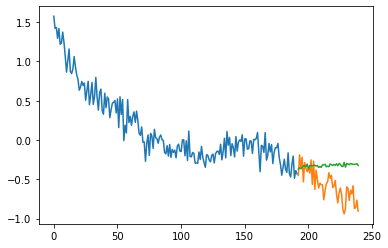

In [97]:
plt.plot(range(train_test_split_index), dataset.masked_simulations[0][:train_test_split_index])
plt.plot(range(train_test_split_index, dataset.masked_simulations[0].shape[0]), test_trajectory)
plt.plot(range(train_test_split_index, dataset.masked_simulations[0].shape[0]), predicted_trajectory)
plt.show()

In [36]:
from statsmodels.tsa.arima.model import ARIMA
import scipy.fftpack
from reservoirpy.nodes import Ridge, Reservoir
from reservoirpy.observables import rmse, rsquare



Running Model-288:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-288: 191it [00:00, 6019.60it/s]           
Running Model-288: 100%|██████████| 1/1 [00:00<00:00, 28.61it/s]


Fitting node Ridge-219...


Running Model-288: 47it [00:00, 5851.36it/s]            
Running Model-289:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-289: 479it [00:00, 6257.11it/s]           
Running Model-289: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


Fitting node Ridge-220...


Running Model-289: 119it [00:00, 6200.28it/s]           
Running Model-290:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-290: 191it [00:00, 6204.26it/s]           
Running Model-290: 100%|██████████| 1/1 [00:00<00:00, 29.93it/s]


Fitting node Ridge-221...


Running Model-290: 47it [00:00, 5980.96it/s]            


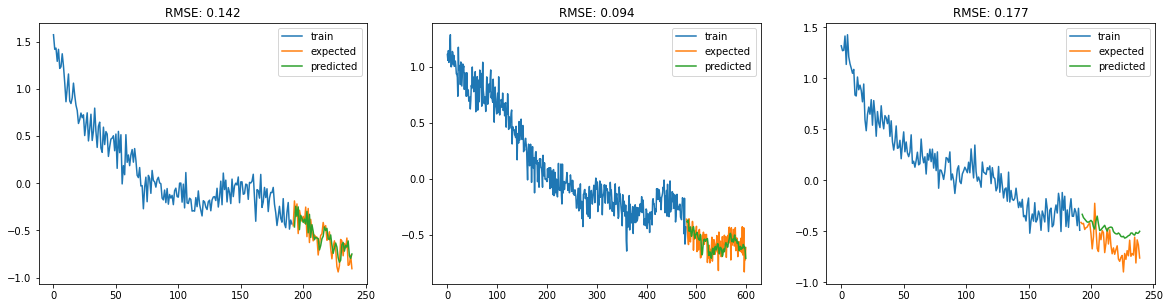

In [94]:
def f(index):
    train_test_split_index = int(len(dataset.masked_simulations[index]) * conf.train_test_split_ratio)
    x = dataset.masked_simulations[index][:train_test_split_index].numpy().squeeze()
    test_trajectory = dataset.masked_simulations[index][train_test_split_index:].numpy().squeeze()
    
    reservoir = Reservoir(units=10, lr=0.8, sr=0.9)
    readout = Ridge(output_dim=1, ridge=1e-6)
    esn = (reservoir) >> readout
    predicted_trajectory = esn.fit(x[:-1, None], x[1:, None]).run(test_trajectory[:-1, None])
    #model = ARIMA(x, order=(12,2,0))
    #model_fit = model.fit()
    #predicted_trajectory = model_fit.forecast(len(test_trajectory))
    plt.plot(range(train_test_split_index), dataset.masked_simulations[index][:train_test_split_index], label="train")
    plt.plot(range(train_test_split_index, dataset.masked_simulations[index].shape[0]), test_trajectory, label="expected")
    plt.plot(range(train_test_split_index+1, dataset.masked_simulations[index].shape[0]), predicted_trajectory, label="predicted")
    plt.title(f"RMSE: {rmse(test_trajectory[1:], np.squeeze(predicted_trajectory)):.3f}")
    plt.legend()

plt.figure(figsize=(20, 4.8))
plt.subplot(1,3,1)
f(0)
plt.subplot(1,3,2)
f(1)
plt.subplot(1,3,3)
f(2)
plt.show()

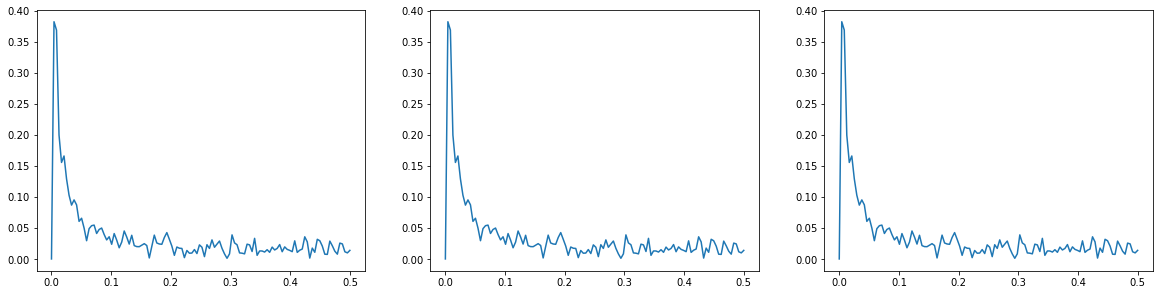

In [195]:
def g(index):
    series = dataset.masked_simulations[0].numpy().squeeze()
    yf = scipy.fftpack.fft(series)
    N = len(series)
    T = 1.
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.figure(figsize=(20, 4.8))
plt.subplot(1,3,1)
g(0)
plt.subplot(1,3,2)
g(1)
plt.subplot(1,3,3)
g(2)
plt.show()

## Result visualization 

In [ ]:
training.test_sample_pca(model, criterion, test_ds, dataset.bool_mask, dataset.pca)
plt.show()

In [ ]:
training.test_sample_pca(model, criterion, test_ds, dataset.bool_mask, dataset.pca)
plt.show()

In [ ]:
losses = training.quantify_quality_average(model, criterion, test_ds, dataset.bool_mask)
plt.plot(losses) ; plt.show()